In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10, CIFAR100
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [3]:
%config Completer.use_jedi = False

In [4]:
path = './datasets/'

transform = transforms.Compose([transforms.ToTensor()])

train_data = CIFAR10(root=path, train=True, transform=transform, download=True)
test_data = CIFAR10(root=path, train=False, transform=transform, download=True)

batch_size = 100

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=4)

print(train_data)
print(test_data)

print(input_shape,output_shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets/
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./datasets/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./datasets/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
3072 10


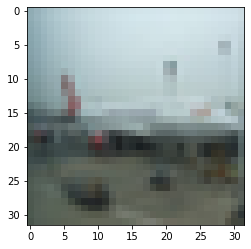

In [28]:
i = np.random.randint(len(train_data))

inputdata = train_data[i][0]
np_data = np.array(inputdata)

plt.imshow(np.transpose(np_data, (1,2,0)))
plt.show()

In [30]:
inputdata.shape

torch.Size([3, 32, 32])

In [27]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [39]:
input_shape = train_data[0][0].reshape(-1).shape[0]
output_shape = len(train_data.classes)

class SoftmaxClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape, 512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256, output_shape))
        
    def forward(self,x):
        return self.layers(x)

In [41]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu:0")

print(device)

model = SoftmaxClassifier().to(device)
loss = nn.CrossEntropyLoss(reduction='sum')

# minimize loss
# minimize loss' = loss + weight_decay * l2_regularization
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

cpu:0


In [ ]:
num_epoch = 100
train_loss_list, test_loss_list = list(), list()

for i in range(num_epoch):
    
    ## train
    total_loss = 0
    count = 0

    for batch_idx, (x, y) in enumerate(train_loader):
        # MNIST: x.shape = (100,784), y.shape = (100,1) = (100,)

        x, y = x.to(device), y.to(device)
        
        pred = model.forward(x)
        cost = loss(pred, y)
        pred_y = F.softmax(pred, dim=-1)
        total_loss += cost.item()

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        pred_val = torch.argmax(pred_y, dim=-1)
        count += (pred_val ** y).sum().item()
        
    acc = count/len(train_data)
    ave_loss = total_loss/len(train_data)

    train_loss_list.append(ave_loss)

    if i % 1 == 0:
        print("\nEpoch %d Train: %.3f / %.3f"%(i,ave_loss,acc))

        
    model.eval()
    
    total_loss = 0
    cnt = 0
    
    with torch.no_grad():
        for batch, (x,y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)


            pred = model.forward(x)
            cost = loss(pred, y)
            pred_y = F.softmax(pred, dim=-1)
            total_loss += cost.item()

            optimizer.zero_grad()
            optimizer.step()

            pred_val = torch.argmax(pred_y, dim=-1)
            cnt += (pred_val ** y).sum().item()

        acc = cnt/len(train_data)
        ave_loss = total_loss/len(train_data)

        train_loss_list.append(ave_loss)

        if i % 1 == 0:
            print("\nEpoch %d Test: %.3f / %.3f"%(i,ave_loss,acc))


Epoch 0 Train: 0.382 / 37404899.311

Epoch 0 Test: 0.814 / 3884593.416

Epoch 1 Train: 0.383 / 37247793.185

Epoch 1 Test: 0.741 / 4566300.781

Epoch 2 Train: 0.377 / 37525905.626

Epoch 2 Test: 0.805 / 3049328.045

Epoch 3 Train: 0.381 / 37425313.829

Epoch 3 Test: 0.717 / 3984673.083

Epoch 4 Train: 0.386 / 37180155.732

Epoch 4 Test: 0.831 / 3915046.336

Epoch 5 Train: 0.365 / 37517946.441

Epoch 5 Test: 1.060 / 4864258.771

Epoch 6 Train: 0.375 / 37338954.116

Epoch 6 Test: 0.749 / 5010128.757

Epoch 7 Train: 0.362 / 37541720.112

Epoch 7 Test: 0.794 / 4694731.118

Epoch 8 Train: 0.357 / 37596102.837

Epoch 8 Test: 0.868 / 4994126.814

Epoch 9 Train: 0.372 / 37434867.270

Epoch 9 Test: 0.833 / 5539244.417

Epoch 10 Train: 0.369 / 37562411.676

Epoch 10 Test: 0.918 / 4812300.018

Epoch 11 Train: 0.383 / 37259837.655

Epoch 11 Test: 0.955 / 4616468.201

Epoch 12 Train: 0.386 / 37351963.886

Epoch 12 Test: 0.884 / 3457018.227

Epoch 13 Train: 0.360 / 37561278.167

Epoch 13 Test: 1.29

In [ ]:
num_parameter = 0

for parameter in model.parameters():
    print(parameter.shape)
    num_parameter += np.prod(parameter.size())
print(num_parameter)